<a href="https://colab.research.google.com/github/iskra3138/colab_repo/blob/master/MVTEC%ED%95%99%EC%8A%B5_GPUs_TFRecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Feb 11 13:25:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

TensorFlow 2.x selected.
Tensorflow version 2.1.0


In [0]:
import re
import numpy as np
from matplotlib import pyplot as plt

In [0]:
import re

BUCKET = "gs://iskra3138_mvtec_tfrecords/"  #@param {type:"string", default:"jddj"}
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'


## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 230 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.

All of these techniques are a bit overkill for our (small) dataset, but demonstrate best practices for using TPUs.


In [0]:
import os

AUTO = tf.data.experimental.AUTOTUNE


IMG_WIDTH = 224 #@param {type:"integer"}
IMG_HEIGHT = 224 #@param {type:"integer"}
IMAGE_SIZE =  [IMG_HEIGHT, IMG_WIDTH]

batch_size = 64 #@param {type:"integer"}

train_fns = os.path.join(BUCKET,'train.tfrecords')
validation_fns = os.path.join(BUCKET,'valid.tfrecords')

def parse_tfrecord(example):
    features = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
      
    label = example['label']
    label = tf.one_hot(indices=label,
                      depth=2
                      )
    image = tf.io.decode_jpeg(example['image_raw'], channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
    return image, label

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset():
  dataset = load_dataset(train_fns)

  # Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set. 
  def data_augment(image, label):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_flip_up_down(modified)
    return modified, label
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)
  
  # Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO) 

training_dataset = get_training_dataset()
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

Let's take a peek at the training dataset we've created:

In [0]:
CLASSES = ['NG', 'OK']

def display_one(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
# If model is provided, use it to generate predictions.
def display_nine(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

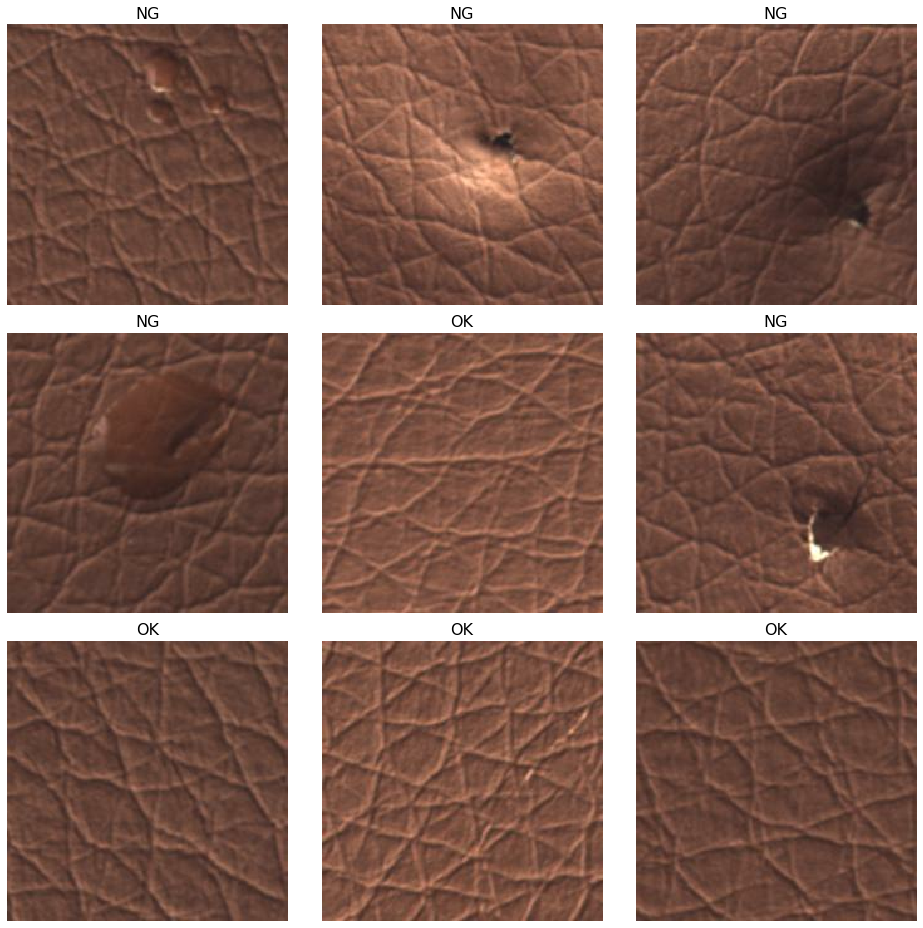

In [7]:
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine(images, labels)

## Model

모델 compile 시, tf.keras.optimizers api를 쓰면 TPU에서는 학습이 되지 않음
- optimizer='adam' <- w/callback : working
- optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4) : working
- optimizer=tf.keras.optimizers.Adam(lr=1e-4) : not working

In [8]:
def create_model():
  pretrained_model = tf.keras.applications.ResNet101(weights='imagenet', input_shape=[*IMAGE_SIZE, 3], include_top=False)
  pretrained_model.trainable = True
  x = pretrained_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax', name='prediction')(x)
  model = tf.keras.Model(inputs=pretrained_model.input, outputs=predictions)
  
  model.compile(
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model


model = create_model()
model.summary()

171450368/171446536 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

## Training

In [9]:
train_samples = sum(1 for _ in tf.data.TFRecordDataset(train_fns))
print (train_samples)

22098


In [0]:
train_steps = train_samples // batch_size

Actually train the model. While the first epoch will be quite a bit slower as we must XLA-compile the execution graph and load the data.

In [0]:
EPOCHS=5
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS,)
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Train for 345 steps
Epoch 1/5
345/345 [==============================] - 221s 641ms/step - loss: 0.0064 - accuracy: 0.9972 - val_loss: 25.8182 - val_accuracy: 0.4353
Epoch 2/5
345/345 [==============================] - 197s 572ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 8.7571 - val_accuracy: 0.4353
Epoch 3/5
345/345 [==============================] - 197s 571ms/step - loss: 3.9421e-06 - accuracy: 1.0000 - val_loss: 1.9630 - val_accuracy: 0.4384
Epoch 4/5
345/345 [==============================] - 197s 572ms/step - loss: 2.1318e-06 - accuracy: 1.0000 - val_loss: 0.1432 - val_accuracy: 0.9682
Epoch 5/5
 69/345 [=====>........................] - ETA: 2:26 - loss: 1.8248e-06 - accuracy: 1.0000

In [0]:
EPOCHS=5
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS,)
final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

In [0]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Accuracy goes up and loss goes down. Looks good!

## Predictions

Let's look at some our model's predictions next to the original images. We'll show 9 images from the validation set.

In [0]:
def img_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = img_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

In [0]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine(images, titles, colors)

## Save and re-loading our trained model

In [0]:
# We can save our model with:
model.save('model.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.h5')

In [0]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, reloaded_model)
display_nine(images, titles, colors)